# Proyek Klasifikasi Gambar: [Rice Image Detection]
- **Nama:** Afifa Nur Mila
- **Email:** mc200d5x2075@student.devacademy.id
- **ID Dicoding:** MC200D5x2075

# Import semua Packages/Library yang digunakan

In [36]:
# Import semua library yang digunakan
import os
import zipfile
import shutil
import random
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

sns.set(style= "darkgrid", color_codes = True)

In [3]:
!pip install tensorflowjs
import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [4]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [5]:
# Mencetak versi tensorflow yang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

In [6]:
# Mengunggah file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"afifamila","key":"80ff190f476d5c46ebb6c605ae034b44"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Mengunduh dataset dari Kaggle mengguanakn kanggle API
!kaggle datasets download -d "muratkokludataset/rice-image-dataset"

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0


In [9]:
!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [10]:
# Dataset path
dataset = 'Rice_Image_Dataset'

In [11]:
# Membuat dataframe untuk menyimpan gambar dan label
images = []  # Inisialisasi gambar dengan membuat list kosong untuk menyimpan gambar
labels = []  # Inisialisasi label dengan membuat list kosong untuk menyimpan label

# Looping melalui subfolder
for subfolder in os.listdir(dataset):

  # Looping melalui subfolder untuk mengetahui label
    subfolder_path = os.path.join(dataset, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

  # Looping melalui gambar dalam subfolder
    for image_filename in os.listdir(subfolder_path):
        # Menambahkan gambar ke dalam list images
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        # Menambahkan nama subfolder sebagai label gambar dalam list label
        labels.append(subfolder)

 # Membuat dataframe yang berisi gambar dan label
df = pd.DataFrame({'image': images, 'label': labels})
df

,image,label
0,Rice_Image_Dataset/Ipsala/Ipsala (6847).jpg,Ipsala
1,Rice_Image_Dataset/Ipsala/Ipsala (12059).jpg,Ipsala
2,Rice_Image_Dataset/Ipsala/Ipsala (14780).jpg,Ipsala
3,Rice_Image_Dataset/Ipsala/Ipsala (2504).jpg,Ipsala
4,Rice_Image_Dataset/Ipsala/Ipsala (620).jpg,Ipsala
...,...,...
74995,Rice_Image_Dataset/Arborio/Arborio (2845).jpg,Arborio
74996,Rice_Image_Dataset/Arborio/Arborio (8978).jpg,Arborio
74997,Rice_Image_Dataset/Arborio/Arborio (11142).jpg,Arborio
74998,Rice_Image_Dataset/Arborio/Arborio (6307).jpg,Arborio


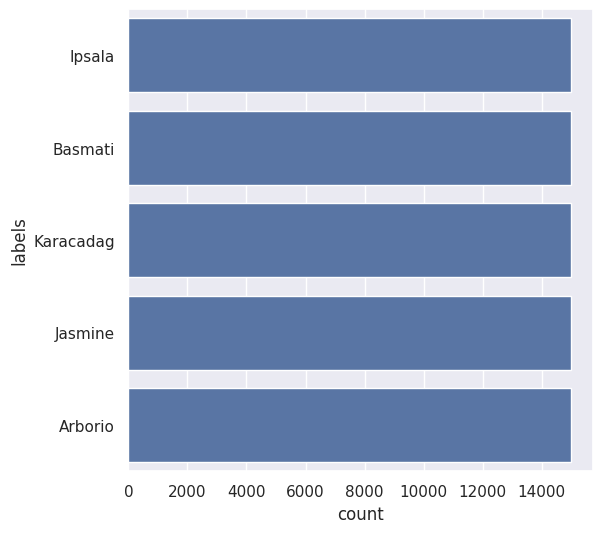

In [12]:
# Distribusi data

# Mengambil informasi dari df yang sudah ada
file_name = df['image'].apply(lambda x: os.path.basename(x)).tolist()  # Mengambil nama file dari path gambar
full_path = df['image'].tolist()  # Mengambil path lengkap gambar
labels = df['label'].tolist()  # Mengambil label gambar

# Membuat DataFrame
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

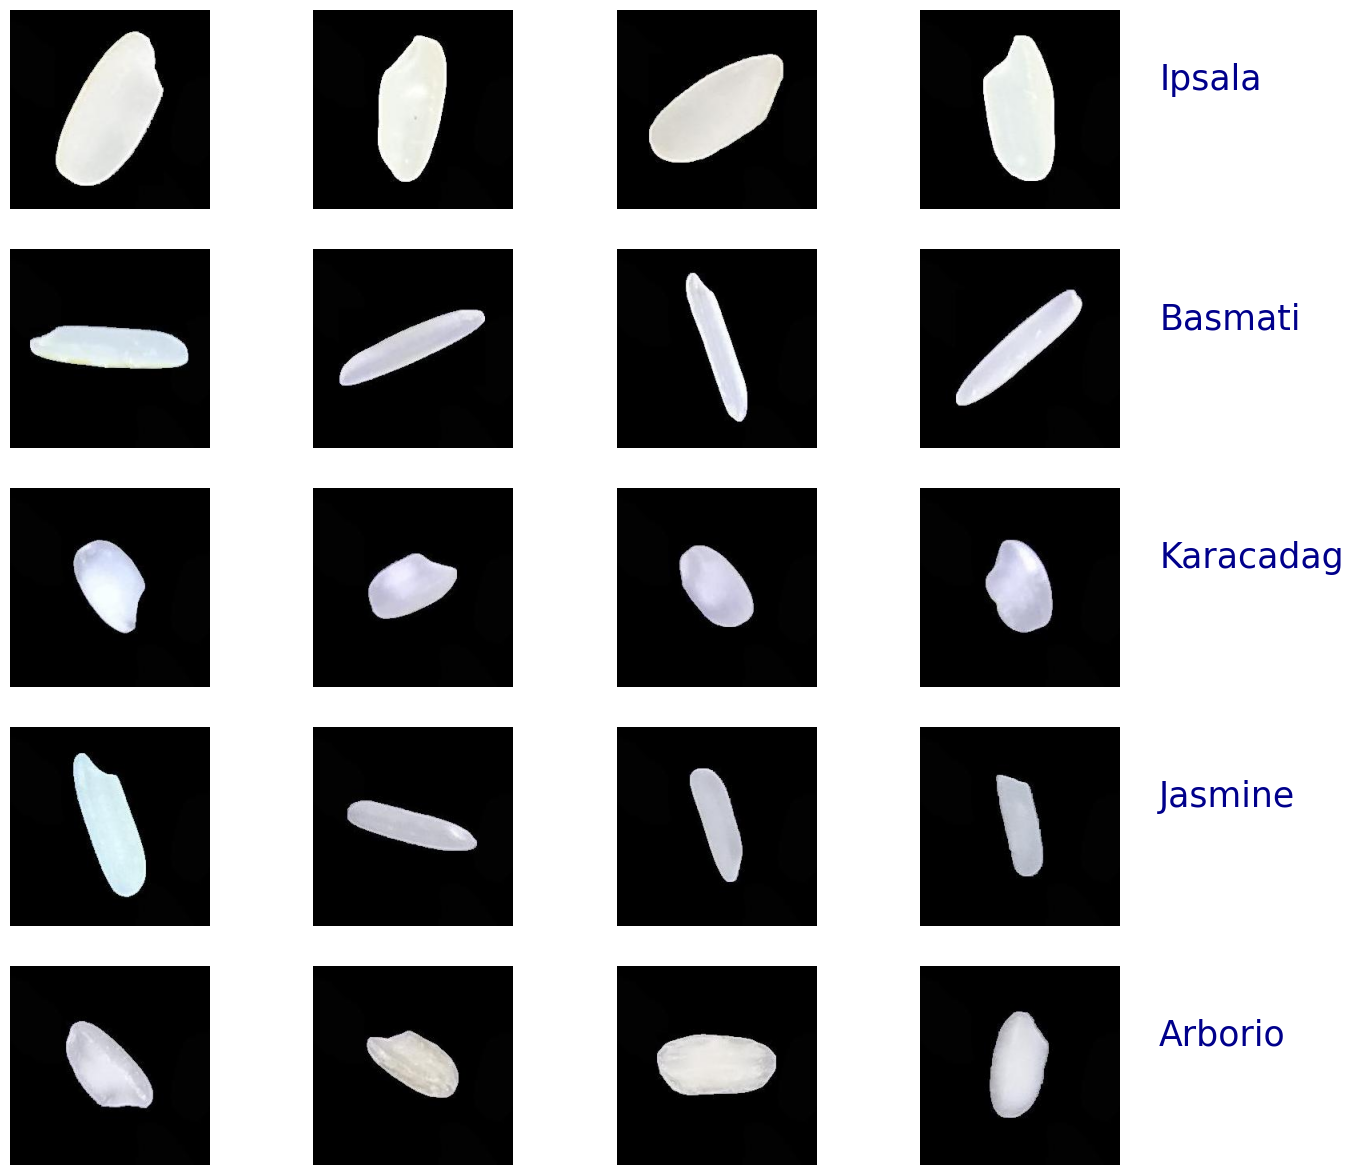

In [13]:
# Membuat figure dan grid
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Looping melalui setiap kategori unik
for i, category in enumerate(df['label'].unique()):
    # Mendapatkan path gambar untuk 4 gambar pertama dalam setiap kategori
    filepaths = df[df['label'] == category]['image'].values[:4]

    # Looping melalui 4 path gambar
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')

    # Menambahkan label kategori
    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

# Data Prepocessing

## Split dataset

In [14]:
# Bagi data ke dalam data train, test, dan validasi
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['image'], df['label'], test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

# Membuat dataframe dari data train
df_train = pd.DataFrame({'image': X_train, 'label': y_train})

# Membuat datframe dari data validasi
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

# Membuat dataframe dari data test
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Melakukan label encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)  # Menggunakan transform bukan fit transform agar encoder yang digunakan konsisten
y_test = encoder.transform(y_test)

## Data Augmentation

In [15]:
# Menentukan ukuran gambar dan jumlah gambar yang akan diproses dalam 1 batch training
image_size = (50, 50)
batch_size = 32

# Membuat objek ImageDataGenerator yang akan digunakan untuk augmentasi dan preprocesing
datagen = ImageDataGenerator(
    rescale=1./255, # skala piksel gambar menjadi rentang 0-1
    rotation_range=45, # rotasi gambar 45 derajat
    width_shift_range=0.2, # menggeser gambar secara horizontal
    height_shift_range=0.2, # menggeser gambar secara vertikal
    shear_range=0.2,# menerapkan transformasi miring
    zoom_range=0.2, # memperbesar atau memperkecil gambar
    horizontal_flip=True, # membalik gambar
    fill_mode='nearest' # mengisi piksel kosong dengan piksel terdekat
)


# Membuat generator data untuk training
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Membuat generator data untuk testing
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Membuat generator data untuk validasi
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 48000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Found 12000 validated image filenames belonging to 5 classes.


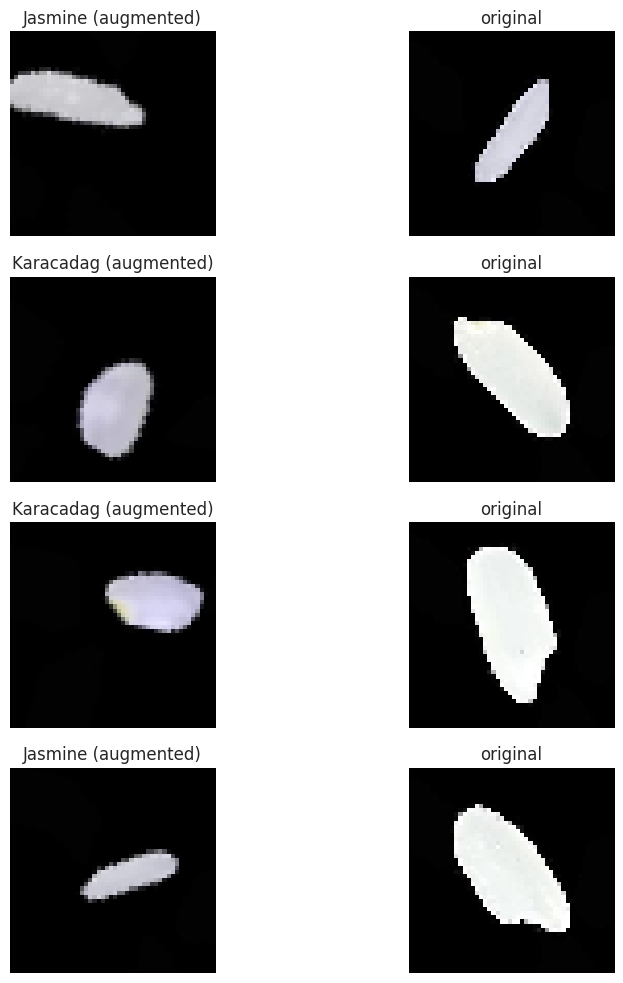

In [18]:
# Mendapatkan nama kelas dari train generator
class_names = list(train_generator.class_indices.keys())

# Visualisasi data hasil augmentasi
plt.figure(figsize=(10, 10))

# Ambil satu batch gambar dari train_generator (sudah diaugmentasi)
image_batch, label_batch = next(train_generator)

# Tentukan jumlah gambar yang ingin divisualisasikan
image_plt_len = min(len(image_batch), 4)

for i in range(image_plt_len):
    # Gambar hasil augmentasi langsung dari train_generator
    plt.subplot(image_plt_len, 2, 2 * i + 1)
    plt.imshow(image_batch[i])
    plt.title(f"{class_names[np.argmax(label_batch[i])]} (augmented)")
    plt.axis("off")

    # Tampilkan gambar asli (tanpa augmentasi) dari file
    # Ambil path file dari dataframe (gunakan indeks yang sama seperti batch)
    original_path = df_train.iloc[i]['image']
    original_img = plt.imread(original_path)

    # Resize agar sesuai dengan image_size
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    img_resized = load_img(original_path, target_size=image_size)
    img_array = img_to_array(img_resized) / 255.0  # skala agar sama dengan hasil augmentasi

    plt.subplot(image_plt_len, 2, 2 * i + 2)
    plt.imshow(img_array)
    plt.title("original")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Modelling

In [19]:
# Menetapkan input shape
input_shape = (50, 50, 3)

# Membuat model sequential
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,397 (3.86 MB)

 Trainable params: 1,011,397 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Simpan model terbaik
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Stop training saat tidak ada peningkatan
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Kurangi learning rate jika tidak membaik
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [23]:
# Training model dengan callback
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7321 - loss: 0.6393
Epoch 1: val_accuracy improved from -inf to 0.93850, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 94s 63ms/step - accuracy: 0.7321 - loss: 0.6392 - val_accuracy: 0.9385 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9271 - loss: 0.1969
Epoch 2: val_accuracy improved from 0.93850 to 0.95192, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 95s 63ms/step - accuracy: 0.9271 - loss: 0.1969 - val_accuracy: 0.9519 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9493 - loss: 0.1372
Epoch 3: val_accuracy improved from 0.95192 to 0.97442, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 62ms/step - accuracy: 0.9493 - loss: 0.1372 - val_accuracy: 0.9744 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 4/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9600 - loss: 0.1115
Epoch 4: val_accuracy did not improve from 0.97442
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 62ms/step - accuracy: 0.9600 - loss: 0.1115 - val_accuracy: 0.9334 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9661 - loss: 0.0932
Epoch 5: val_accuracy improved from 0.97442 to 0.97967, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 62ms/step - accuracy: 0.9661 - loss: 0.0932 - val_accuracy: 0.9797 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 6/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9696 - loss: 0.0845
Epoch 6: val_accuracy did not improve from 0.97967
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.9696 - loss: 0.0845 - val_accuracy: 0.9633 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 7/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9734 - loss: 0.0763
Epoch 7: val_accuracy improved from 0.97967 to 0.98117, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.9734 - loss: 0.0763 - val_accuracy: 0.9812 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9770 - loss: 0.0642
Epoch 8: val_accuracy did not improve from 0.98117
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 103s 69ms/step - accuracy: 0.9770 - loss: 0.0642 - val_accuracy: 0.9756 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9809 - loss: 0.0567
Epoch 9: val_accuracy did not improve from 0.98117
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.9809 - loss: 0.0567 - val_accuracy: 0.9799 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9817 - loss: 0.0517
Epoch 10: val_accuracy improved from 0.98117 to 0.98283, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 62ms/step - accuracy: 0.9817 - loss: 0.0517 - val_accuracy: 0.9828 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 11/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9822 - loss: 0.0494
Epoch 11: val_accuracy improved from 0.98283 to 0.98475, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 91s 61ms/step - accuracy: 0.9822 - loss: 0.0494 - val_accuracy: 0.9847 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9851 - loss: 0.0446
Epoch 12: val_accuracy improved from 0.98475 to 0.98592, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 102s 68ms/step - accuracy: 0.9851 - loss: 0.0446 - val_accuracy: 0.9859 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 13/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9835 - loss: 0.0458
Epoch 13: val_accuracy did not improve from 0.98592
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9835 - loss: 0.0458 - val_accuracy: 0.9670 - val_loss: 0.0971 - learning_rate: 0.0010
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9871 - loss: 0.0379
Epoch 14: val_accuracy improved from 0.98592 to 0.98833, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.9871 - loss: 0.0379 - val_accuracy: 0.9883 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 15/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9873 - loss: 0.0360
Epoch 15: val_accuracy did not improve from 0.98833
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 62ms/step - accuracy: 0.9872 - loss: 0.0360 - val_accuracy: 0.9880 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 16/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9871 - loss: 0.0371
Epoch 16: val_accuracy did not improve from 0.98833
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 91s 61ms/step - accuracy: 0.9871 - loss: 0.0371 - val_accuracy: 0.9712 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 17/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9879 - loss: 0.0360
Epoch 17: val_accuracy did not improve from 0.98833

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 62ms/step - accuracy: 0.98

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.9938 - loss: 0.0201 - val_accuracy: 0.9927 - val_loss: 0.0201 - learning_rate: 3.0000e-04
Epoch 19/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9941 - loss: 0.0175
Epoch 19: val_accuracy did not improve from 0.99275
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 62ms/step - accuracy: 0.9941 - loss: 0.0175 - val_accuracy: 0.9911 - val_loss: 0.0252 - learning_rate: 3.0000e-04
Epoch 20/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9934 - loss: 0.0189
Epoch 20: val_accuracy improved from 0.99275 to 0.99325, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.9934 - loss: 0.0189 - val_accuracy: 0.9933 - val_loss: 0.0229 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 20.


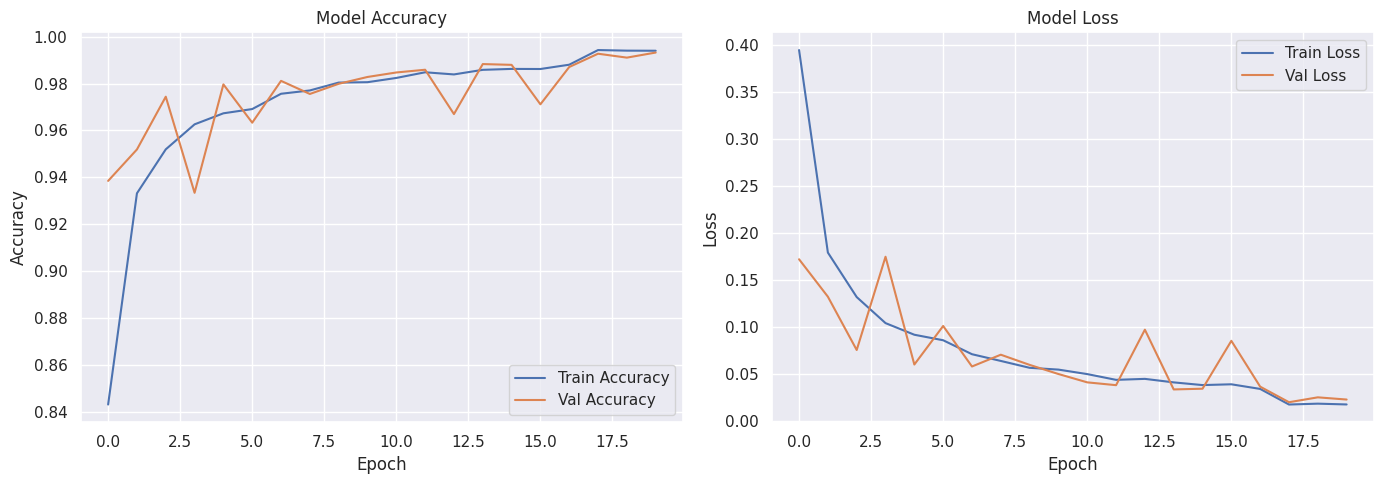

In [24]:
plt.figure(figsize=(14,5))

# Plot Akurasi
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi dan Visualisasi

In [25]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.9933 - loss: 0.0190
Test Accuracy: 99.27%




              precision    recall  f1-score   support

     Arborio     0.9801    0.9935    0.9868      2929
     Basmati     0.9980    0.9937    0.9958      2995
      Ipsala     0.9993    1.0000    0.9997      2997
     Jasmine     0.9880    0.9880    0.9880      2996
   Karacadag     0.9990    0.9896    0.9943      3083

    accuracy                         0.9929     15000
   macro avg     0.9929    0.9930    0.9929     15000
weighted avg     0.9930    0.9929    0.9929     15000



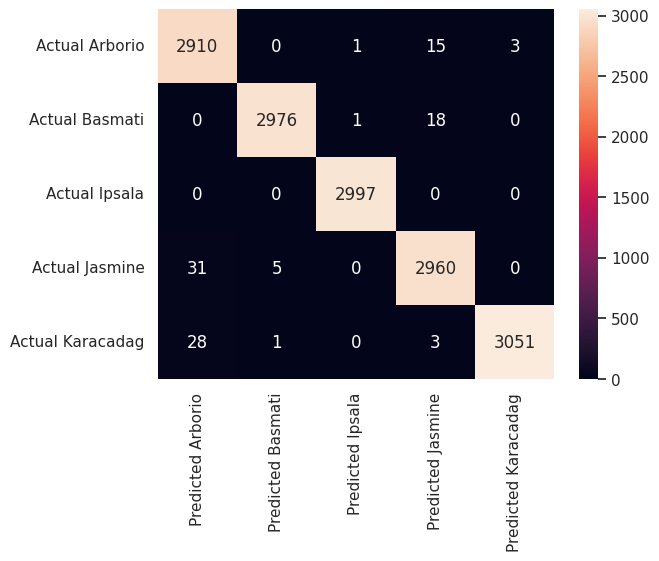

In [26]:
# Reset test generator
test_generator.reset()

# Menggunakan model yang sudah dilatih
preds_1 = model.predict(test_generator, verbose=0)

# Get predicted class indices
predicted_classes = np.argmax(preds_1, axis=1)

# Dapatkan daftar nama kelas dari test_generator
class_names = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_classes, labels=np.unique(test_generator.classes)),
                  index=[f"Actual {name}" for name in class_names],
                  columns=[f"Predicted {name}" for name in class_names])
sns.heatmap(cm, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=predicted_classes, target_names=class_names, digits=4))

# Save the Model

In [27]:
#Save Model
model.save('rice_classification_saved_model.h5')

# Mount Google Drive
drive.mount('/content/drive')

# Load your Keras model
model = load_model('rice_classification_saved_model.h5')

# Define the base save path in Google Drive
base_save_path = '/content/drive/My Drive/rice_image_classification_model'  # Change to your desired base path

# 1. Save as SavedModel
saved_model_path = os.path.join(base_save_path, 'saved_model')
tf.saved_model.save(model, saved_model_path)
print(f"SavedModel saved to: {saved_model_path}")

# 2. Save as TF Lite
tflite_path = os.path.join(base_save_path, 'tflite')
os.makedirs(tflite_path, exist_ok=True)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(os.path.join(tflite_path, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)
print(f"TF Lite model saved to: {tflite_path}")

# Save label
with open(os.path.join(tflite_path, 'label.txt'), 'w') as f:
   f.write('\n'.join(class_names)) # Assuming class_names is defined

# 3. Save as TFJS
tfjs_path = os.path.join(base_save_path, 'tfjs_model')
tfjs.converters.save_keras_model(model, tfjs_path)
print(f"TFJS model saved to: {tfjs_path}")

Mounted at /content/drive
SavedModel saved to: /content/drive/My Drive/rice_image_classification_model/saved_model
Saved artifact at '/tmp/tmp2im8xmb8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133712345787344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345787152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345788496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345787728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345789648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345790992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345789456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133712345789264: TensorSpec(shape=(), dtype=tf.resource, name=None)


TF Lite model saved to: /content/drive/My Drive/rice_image_classification_model/tflite
failed to lookup keras version from the file,
    this is likely a weight only file
TFJS model saved to: /content/drive/My Drive/rice_image_classification_model/tfjs_model


# Inference

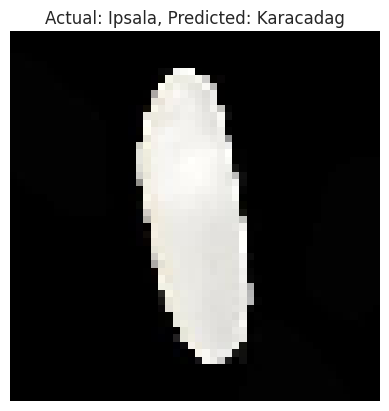

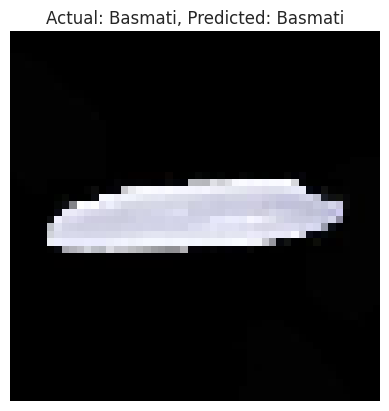

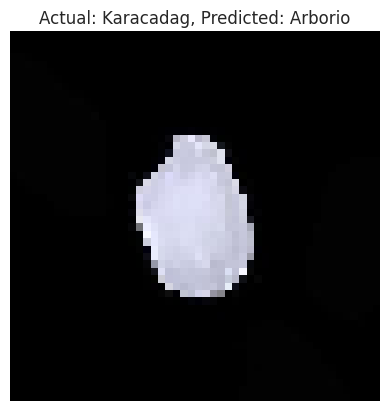

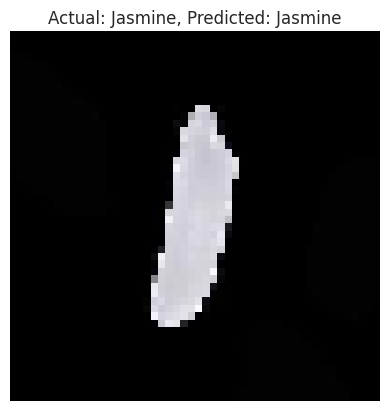

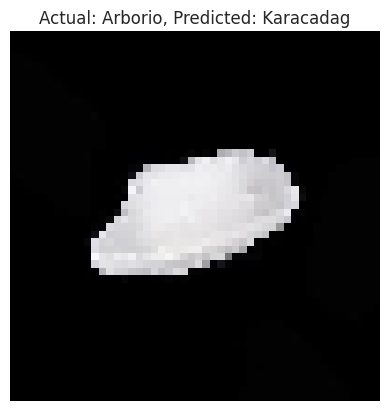

In [38]:
# Load the SavedModel
model = tf.saved_model.load('/content/drive/My Drive/rice_image_classification_model/saved_model')

# Define the path to the dataset
dataset_path = 'Rice_Image_Dataset'

# Get a list of unique class names, excluding files
class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Loop through each class and predict on one image
for class_name in class_names:
    # Get a list of all image files in the class folder
    image_files = os.listdir(os.path.join(dataset_path, class_name))

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Get the path to the first (now randomly selected) image in the class folder
    image_path = os.path.join(dataset_path, class_name, image_files[0])

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(50, 50))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize the image

    # Make the prediction using the loaded SavedModel
    infer = model.signatures['serving_default']
    predictions = infer(inputs=tf.convert_to_tensor(img_array, dtype=tf.float32))

    # Get the prediction from the output tensor
    predictions = predictions[list(predictions.keys())[0]].numpy()
    predicted_class_index = np.argmax(predictions)

    # Use the filtered class_names for prediction
    predicted_class_name = class_names[predicted_class_index]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

In [39]:
!pip freeze > requirements.txt

In [41]:
from google.colab import files
files.download('requirements.txt') # Download requirements.txt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>